# Problem for Challenge: Recommending News to read based on Reader's interest.
## Problem formation is a bit complicated since there are no explicit label to use on the data, so i am creating a label with a kmeans cluster algorithm. 

### The steps taken to achieve this is as follows:
1. Create a Sentence Embeddings: I will be using the Tensorflow's sentence Encoder due to time constraints and will not be buiding a sentece Encoder for a start. Tensorflow's sentence encoder is available at https://tfhub.dev/google/universal-sentence-encoder/4. The output is a 512 long 1 dimension vector for each sentence fed into the network


2. Label data with Kmeans Algorithm: We find the optimal number of cluster for the dataset. However, i have considered limiting the number of Cluster to a maximum of 100. This is due to computational power that is required as number of cluster increases. We find the OPtimal number between 10 - 100

3. Build a prediction Model: This is very optional, However, to reduce the inference time since we have to find the distance to all the clusters to find where a sentence belong, we are doing this to help us reduce that time. A model will learn and capture the weigths that predict the cluster where a sentence should belong


4. After Prediction, we only compare the sentence embeddings in that cluster and recommend the top 5 news ranked by earlier dates and Up_votes. This is very important since we assume readers will only be interested in newest news with highest up_votes

In [ ]:
!pip3 install gensim>0
!pip3 install tensorflow_hub >0
!pip3 install seaborn > 0
print("succesfully installed dependence")

succesfully installed dependence


In [1]:

# Import Modules
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
from embed import embed # Sentence embedding with tensorflowHub. see embed.py
from keras import backend as K

import numpy.linalg as nla
import sys
from train import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
tf.compat.v1.disable_eager_execution()

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [36]:
dataset = pd.read_csv("Eluvio_DS_Challenge.csv", delimiter= ",")

In [8]:
dataset.head(10) # Let us see our data from the Top

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews
5,1201287889,2008-01-25,15,0,Hay presto! Farmer unveils the illegal mock-...,False,Armagedonovich,worldnews
6,1201289438,2008-01-25,5,0,"Strikes, Protests and Gridlock at the Poland-U...",False,Clythos,worldnews
7,1201536662,2008-01-28,0,0,The U.N. Mismanagement Program,False,Moldavite,worldnews
8,1201558396,2008-01-28,4,0,Nicolas Sarkozy threatens to sue Ryanair,False,Moldavite,worldnews
9,1201635869,2008-01-29,3,0,US plans for missile shields in Polish town me...,False,JoeyRamone63,worldnews


In [9]:
dataset.tail(10) # Let us see our data from the buttom

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
509226,1479815901,2016-11-22,2,0,Egyptian ex-President Morsy s life sentence ov...,False,golden430,worldnews
509227,1479816098,2016-11-22,4,0,Turkey says child rape pardon law can be amend...,False,mileyscience,worldnews
509228,1479816284,2016-11-22,4,0,Four charged with plotting to assassinate late...,False,mossbergGT,worldnews
509229,1479816315,2016-11-22,0,0,Indian Demonetisation: Most sweeping change in...,False,Randiathrowaway1,worldnews
509230,1479816582,2016-11-22,2,0,EU conservative slams Johnson s arrogant prov...,False,k4lifrag,worldnews
509231,1479816764,2016-11-22,5,0,Heil Trump : Donald Trump s alt-right white...,False,nonamenoglory,worldnews
509232,1479816772,2016-11-22,1,0,There are people speculating that this could b...,False,SummerRay,worldnews
509233,1479817056,2016-11-22,1,0,Professor receives Arab Researchers Award,False,AUSharjah,worldnews
509234,1479817157,2016-11-22,1,0,Nigel Farage attacks response to Trump ambassa...,False,smilyflower,worldnews
509235,1479817346,2016-11-22,1,0,Palestinian wielding knife shot dead in West B...,False,superislam,worldnews


### Explore Columns on dataset

In [10]:
dataset["title"].nunique() # Some titles are the same? Explore Futher

500720

In [11]:
dataset["title"].value_counts()

Brutality of Syrian Rebels Posing Dilemma in West                    6
Obama Administration Ends Pentagon Program to Train Syrian Rebels    5
China disrupts Google services ahead of Tiananmen anniversary        5
Putin nominated for Nobel Peace Prize                                5
New SARS-like virus is a  threat to the entire world                 5
                                                                    ..
Britain Says Will Not Work with Assad to Combat Islamic State        1
Abortion reforms divide Ireland                                      1
Putin Sends Nuclear Bombers Over the English Channel.                1
Venezuela s first imported oil shipment departs from Algeria         1
Yemen conflict fans food insecurity                                  1
Name: title, Length: 500720, dtype: int64

In [12]:
dataset[dataset["title"] == "Brutality of Syrian Rebels Posing Dilemma in West"] #Lets see if the first from the top number of title has the same author

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
210607,1378383474,2013-09-05,19,0,Brutality of Syrian Rebels Posing Dilemma in West,False,Jewpiter,worldnews
210632,1378390466,2013-09-05,28,0,Brutality of Syrian Rebels Posing Dilemma in West,False,0x0E,worldnews
210685,1378398812,2013-09-05,7,0,Brutality of Syrian Rebels Posing Dilemma in West,False,emr1028,worldnews
210720,1378405690,2013-09-05,12,0,Brutality of Syrian Rebels Posing Dilemma in West,False,erowidtrance,worldnews
210805,1378426373,2013-09-06,31,0,Brutality of Syrian Rebels Posing Dilemma in West,False,GreyMatter22,worldnews
210806,1378426406,2013-09-06,57,0,Brutality of Syrian Rebels Posing Dilemma in West,False,BillTowne,worldnews


### There are titles that occurs twice or more, Even though they are not from the same author, Majority were posted the same date. I will be picking only title with the highest up vote Since our recommendation software will pick one with earliest date and highest vote. Every news in our new dataset will have only one entry with the highest UP_VOTES

In [37]:
# Drop Duplicates in title and replace by one with the Highest Up vote
new_dataset = dataset.sort_values('up_votes', ascending=False).drop_duplicates('title').sort_index().reset_index(drop=True)

In [38]:
new_dataset # Let us explore again, we now have the same length as the data from unique data from length

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews
...,...,...,...,...,...,...,...,...
500715,1479816764,2016-11-22,5,0,Heil Trump : Donald Trump s alt-right white...,False,nonamenoglory,worldnews
500716,1479816772,2016-11-22,1,0,There are people speculating that this could b...,False,SummerRay,worldnews
500717,1479817056,2016-11-22,1,0,Professor receives Arab Researchers Award,False,AUSharjah,worldnews
500718,1479817157,2016-11-22,1,0,Nigel Farage attacks response to Trump ambassa...,False,smilyflower,worldnews


In [39]:
new_dataset["category"].nunique() # See Category #Nothing interesting

1

In [40]:
new_dataset["over_18"].nunique() 

2

### The Kmeans Algorithm is used to create a cluster and categorize the title column of the dataset to similar titles in the dataset. This is Implemented Next

In [17]:
title = new_df["title"]

In [18]:
# Create embeddings for the title column of the dataset with the hub setence embedding model 
embeddings = np.zeros(shape=(len(title), 512), dtype=np.float32)
for i in range(len(title)):
    embeddings[i, :] = embed([title[i]])

In [19]:
embeddings_df = pd.DataFrame(embeddings)

In [20]:
columns = [i for i in range(512)] # create Column name 0-512
embeddings_df.columns = columns
embeddings_df.to_csv("embeddings.csv", index=False)

In [ ]:
embeddings_df = pd.read_csv("embeddings.csv")

In [21]:
embeddings_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,0.003107,-0.003184,-0.006828,0.006971,0.043481,-0.082722,-0.039828,0.018468,-0.052266,0.004955,0.078865,-0.064420,-0.044833,-0.045961,0.048409,-0.037289,0.012923,0.062912,0.022681,0.015250,-0.048311,0.075218,0.039940,-0.056849,-0.000488,-0.071658,0.065354,0.053098,-0.058265,0.040815,0.058111,-0.014319,-0.002031,0.084248,0.024181,0.068584,0.012397,0.001108,-0.080744,0.001745,...,-0.005456,0.059487,0.007008,-0.000593,0.033145,-0.018501,0.001774,0.044840,0.017434,0.038611,0.021536,0.050985,0.062390,-0.040772,0.043542,0.024854,-0.066180,-0.004114,0.015144,0.018231,0.032378,0.020784,-0.004004,-0.010598,0.017758,-0.006152,-0.032630,-0.045041,-0.028643,-0.015990,0.016969,0.033176,-0.027678,-0.039699,-0.017533,-0.039356,-0.020977,0.011524,-0.069030,-0.081840
1,-0.035457,-0.022433,-0.068488,0.031860,0.031563,0.025695,-0.049240,0.015961,-0.042801,-0.068648,-0.003352,-0.040486,-0.032265,-0.062944,0.072209,-0.039478,0.006139,0.013131,-0.045770,-0.009891,-0.051055,0.030383,-0.055024,0.055198,0.022805,-0.011005,-0.060249,0.008462,-0.075566,0.024584,0.013616,-0.066011,-0.008470,-0.016514,-0.056630,0.056346,-0.074833,0.043095,0.038810,0.019623,...,0.016715,-0.065063,-0.057704,0.021187,0.017059,-0.069275,-0.056403,0.050439,0.070138,-0.012010,-0.000203,0.024052,0.043997,-0.060241,0.024314,0.075488,0.020740,-0.046087,-0.056673,0.029920,-0.031725,0.072560,0.034492,0.030407,0.009550,-0.021792,-0.018585,-0.005206,-0.076765,0.010658,0.066956,-0.020707,0.010887,-0.047639,-0.008529,-0.049709,0.037194,-0.010999,0.046840,-0.080371
2,0.016872,-0.036315,0.073070,0.050996,-0.040651,0.048655,-0.020900,0.018896,-0.002318,-0.043940,0.067441,0.034458,-0.050003,-0.050420,0.070480,-0.056355,-0.029449,0.073961,-0.063579,0.040134,-0.004478,-0.068054,-0.022463,0.013283,0.007041,0.058778,-0.065736,0.074739,0.056789,0.013326,-0.060684,0.043097,0.056090,0.063211,0.035758,0.077240,0.023047,0.072464,0.057512,0.010938,...,0.009558,-0.026510,-0.063444,-0.015002,0.026118,-0.072331,-0.039913,0.009242,-0.009141,0.035944,0.038217,0.031515,0.016775,-0.012801,-0.059416,-0.044408,0.065882,-0.032734,0.008956,-0.039253,0.040723,0.018162,0.022552,0.072251,0.037282,-0.067104,-0.036358,0.039664,0.024857,-0.023006,0.006474,0.052621,0.031295,-0.051462,-0.013672,0.080687,0.012485,0.036704,-0.067177,-0.080425
3,-0.022989,-0.097950,0.021427,-0.024405,-0.000692,-0.007434,-0.004825,-0.014889,0.073260,-0.063268,0.075512,-0.051385,0.026537,-0.081691,0.028761,-0.087201,-0.100464,0.038551,-0.008069,-0.017583,-0.077133,0.005229,0.045188,-0.030530,-0.034996,-0.071824,-0.052508,0.034215,0.007112,0.044553,0.010310,0.101803,0.030219,-0.030924,-0.040177,0.034572,0.008126,-0.020646,-0.022655,-0.077187,...,-0.001525,0.058374,-0.019751,0.004608,-0.057502,0.028262,0.022191,0.015199,-0.048260,-0.002748,0.017017,0.000256,-0.027496,0.037043,-0.036873,-0.020652,-0.000644,0.026779,-0.053885,-0.058570,0.017597,0.022592,0.031426,-0.048772,-0.026300,0.002380,-0.083212,-0.029333,-0.053942,-0.041351,-0.038799,0.075244,-0.046416,-0.097909,0.038537,0.009044,-0.001793,0.044079,0.015732,-0.003692
4,0.043224,0.014872,0.035046,-0.018529,0.012838,-0.068413,-0.032989,-0.013875,-0.018587,-0.033483,0.080846,0.028803,0.029575,-0.006204,0.045417,-0.051544,0.053372,0.012941,0.012706,0.035758,-0.051748,-0.003657,-0.057392,0.021039,-0.012179,-0.039071,0.054841,-0.052916,0.055065,0.035366,0.002864,0.051577,0.049387,0.084082,0.045128,-0.025311,0.030234,0.031797,-0.009426,-0.054029,...,0.042555,0.027808,0.004720,0.067981,-0.026994,-0.051088,0.043873,0.076705,0.002608,0.041388,-0.070944,-0.033188,0.009803,0.030709,0.018291,-0.028403,0.033670,-0.026290,0.036503,-0.027670,-0.014030,0.004966,0.068932,0.045142,0.024733,-0.000508,-0.017387,0.060045,-0.061889,-0.0496

In [ ]:
# # We are making sure the embeddings are in its right shape

# embeddings = np.stack(embeddings)
# embeddings = np.reshape(embeddings, (-1, 512))

In [22]:
# Length should be equal to the length of title
len(embeddings_df) == len(title)

True

In [23]:
embeddings_columns = embeddings_df.columns

In [41]:
from kmeans import  kmeans

In [25]:
k = 1

embeddings_df['centroid'] = k
# initialize the points to centroid distance to an impossible value "2" (>1)
embeddings_df['pt2centroid'] = 2

Kmeans is an Unsupervised Learning so we must design a measure to know when we are doing good. Here, I am using the sum of distance to each point to pick the uptimal number of cluster from 10-100

In [27]:
# Plot loss vs number of clusters
def lossRange(kmin, kmax, kstep, data_df):
  kmax += 1  # include kmax-th cluster in range
  clusterRange = range(kmin, kmax, kstep)
  loss = np.zeros(len(clusterRange))
  lossCtr = 0
  for cluster in clusterRange:
    [data_df, centroids] = kmeans(data_df, cluster, embeddings_columns, 0)
    loss[lossCtr] = np.sum(data_df['pt2centroid'])
    lossCtr += 1
    print(cluster)
  plt.scatter(clusterRange, loss)
  plt.title('Loss vs Clusters Used')
  plt.xlabel('Number of clusters')
  plt.ylabel('Total Point-to-Centroid Distance')



From below, we can see how distance reduces drastically as number of clusters increases. However, there is no significant changes at 80 and 100 cluster so i am going to choose 80 as my number of cluster and Label (0-80)

k-means converged for 10 clusters after 178 iterations!
10
k-means converged for 20 clusters after 138 iterations!
20
k-means converged for 30 clusters after 141 iterations!
30
k-means converged for 40 clusters after 132 iterations!
40
k-means converged for 50 clusters after 233 iterations!
50
k-means converged for 60 clusters after 127 iterations!
60
k-means converged for 70 clusters after 178 iterations!
70
k-means converged for 80 clusters after 230 iterations!
80
k-means converged for 90 clusters after 183 iterations!
90
k-means converged for 100 clusters after 148 iterations!
100


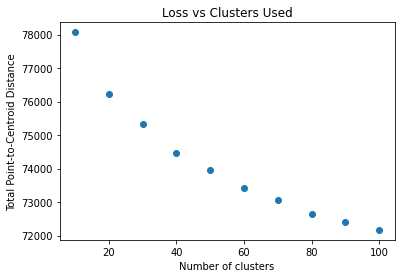

In [28]:
#This is going to take a long more time to run so i comment this out
kmin = 10 
kmax = 100
kstep = 10
lossRange(kmin, kmax, kstep, embeddings_df)

In [29]:
k = 80

embeddings_df['centroid'] = k
# init the point to centroid distance to an impossible value "2" (>1)
embeddings_df['pt2centroid'] = 2

new_df, cent = kmeans(embeddings_df, k, embeddings_columns, 0)

k-means converged for 80 clusters after 195 iterations!


In [30]:
new_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,centroid,pt2centroid
0,0.003107,-0.003184,-0.006828,0.006971,0.043481,-0.082722,-0.039828,0.018468,-0.052266,0.004955,0.078865,-0.064420,-0.044833,-0.045961,0.048409,-0.037289,0.012923,0.062912,0.022681,0.015250,-0.048311,0.075218,0.039940,-0.056849,-0.000488,-0.071658,0.065354,0.053098,-0.058265,0.040815,0.058111,-0.014319,-0.002031,0.084248,0.024181,0.068584,0.012397,0.001108,-0.080744,0.001745,...,0.007008,-0.000593,0.033145,-0.018501,0.001774,0.044840,0.017434,0.038611,0.021536,0.050985,0.062390,-0.040772,0.043542,0.024854,-0.066180,-0.004114,0.015144,0.018231,0.032378,0.020784,-0.004004,-0.010598,0.017758,-0.006152,-0.032630,-0.045041,-0.028643,-0.015990,0.016969,0.033176,-0.027678,-0.039699,-0.017533,-0.039356,-0.020977,0.011524,-0.069030,-0.081840,68,0.116707
1,-0.035457,-0.022433,-0.068488,0.031860,0.031563,0.025695,-0.049240,0.015961,-0.042801,-0.068648,-0.003352,-0.040486,-0.032265,-0.062944,0.072209,-0.039478,0.006139,0.013131,-0.045770,-0.009891,-0.051055,0.030383,-0.055024,0.055198,0.022805,-0.011005,-0.060249,0.008462,-0.075566,0.024584,0.013616,-0.066011,-0.008470,-0.016514,-0.056630,0.056346,-0.074833,0.043095,0.038810,0.019623,...,-0.057704,0.021187,0.017059,-0.069275,-0.056403,0.050439,0.070138,-0.012010,-0.000203,0.024052,0.043997,-0.060241,0.024314,0.075488,0.020740,-0.046087,-0.056673,0.029920,-0.031725,0.072560,0.034492,0.030407,0.009550,-0.021792,-0.018585,-0.005206,-0.076765,0.010658,0.066956,-0.020707,0.010887,-0.047639,-0.008529,-0.049709,0.037194,-0.010999,0.046840,-0.080371,46,0.143483
2,0.016872,-0.036315,0.073070,0.050996,-0.040651,0.048655,-0.020900,0.018896,-0.002318,-0.043940,0.067441,0.034458,-0.050003,-0.050420,0.070480,-0.056355,-0.029449,0.073961,-0.063579,0.040134,-0.004478,-0.068054,-0.022463,0.013283,0.007041,0.058778,-0.065736,0.074739,0.056789,0.013326,-0.060684,0.043097,0.056090,0.063211,0.035758,0.077240,0.023047,0.072464,0.057512,0.010938,...,-0.063444,-0.015002,0.026118,-0.072331,-0.039913,0.009242,-0.009141,0.035944,0.038217,0.031515,0.016775,-0.012801,-0.059416,-0.044408,0.065882,-0.032734,0.008956,-0.039253,0.040723,0.018162,0.022552,0.072251,0.037282,-0.067104,-0.036358,0.039664,0.024857,-0.023006,0.006474,0.052621,0.031295,-0.051462,-0.013672,0.080687,0.012485,0.036704,-0.067177,-0.080425,55,0.135702
3,-0.022989,-0.097950,0.021427,-0.024405,-0.000692,-0.007434,-0.004825,-0.014889,0.073260,-0.063268,0.075512,-0.051385,0.026537,-0.081691,0.028761,-0.087201,-0.100464,0.038551,-0.008069,-0.017583,-0.077133,0.005229,0.045188,-0.030530,-0.034996,-0.071824,-0.052508,0.034215,0.007112,0.044553,0.010310,0.101803,0.030219,-0.030924,-0.040177,0.034572,0.008126,-0.020646,-0.022655,-0.077187,...,-0.019751,0.004608,-0.057502,0.028262,0.022191,0.015199,-0.048260,-0.002748,0.017017,0.000256,-0.027496,0.037043,-0.036873,-0.020652,-0.000644,0.026779,-0.053885,-0.058570,0.017597,0.022592,0.031426,-0.048772,-0.026300,0.002380,-0.083212,-0.029333,-0.053942,-0.041351,-0.038799,0.075244,-0.046416,-0.097909,0.038537,0.009044,-0.001793,0.044079,0.015732,-0.003692,29,0.167074
4,0.043224,0.014872,0.035046,-0.018529,0.012838,-0.068413,-0.032989,-0.013875,-0.018587,-0.033483,0.080846,0.028803,0.029575,-0.006204,0.045417,-0.051544,0.053372,0.012941,0.012706,0.035758,-0.051748,-0.003657,-0.057392,0.021039,-0.012179,-0.039071,0.054841,-0.052916,0.055065,0.035366,0.002864,0.051577,0.049387,0.084082,0.045128,-0.025311,0.030234,0.031797,-0.009426,-0.054029,...,0.004720,0.067981,-0.026994,-0.051088,0.043873,0.076705,0.002608,0.041388,-0.070944,-0.033188,0.009803,0.030709,0.018291,-0.028403,0.033670,-0.026290,0.036503,-0.027670,-0.014030,0.004966,0.068932,0.045142,0.024733,-0.000508,-0.017387,0.060045,-0.061889,-0.049686,-0.052595,0.045081,0.036687,0.

In [31]:
new_df.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,centroid,pt2centroid
500715,0.045091,0.025798,-0.041285,-0.026933,-0.010562,-0.016946,0.051068,-0.024070,-0.038837,0.039609,0.027759,0.038489,-0.064974,-0.017113,0.047686,-0.068042,0.003590,-0.063265,0.016486,0.001790,0.024205,0.017383,-0.026215,0.007425,0.018233,-0.006160,-0.038715,0.008207,0.050315,0.053099,0.027127,-0.051892,0.035927,-0.067892,0.031706,-0.027151,0.011875,0.001230,-0.066857,0.030943,...,-0.044169,0.045924,-0.014841,-0.006459,-0.057364,-0.002033,-0.045118,0.014706,0.061913,-0.049861,0.005717,-0.042730,-0.040327,-0.062717,0.032598,-0.063010,0.009220,0.067560,-0.043752,0.019791,-0.012016,-0.067682,0.037126,-0.004189,-0.067657,-0.059512,0.068041,0.046873,0.032892,0.066071,0.013054,0.001252,0.022979,0.030305,-0.000500,0.031251,-0.050470,-0.065275,54,0.156471
500716,0.003256,0.079482,0.002693,-0.052646,-0.041810,-0.060807,0.027935,-0.007780,-0.027788,-0.067750,0.050608,0.035685,0.071243,0.077987,-0.069370,-0.080179,-0.072148,-0.005609,-0.042445,0.030859,0.041716,-0.067674,-0.041934,0.040013,-0.050943,0.076960,0.012653,-0.047564,0.051002,0.021545,-0.039934,-0.063782,-0.009105,0.017873,0.071662,-0.028738,-0.072858,0.042915,0.036844,-0.047291,...,-0.076565,-0.026342,-0.061601,0.038271,0.030658,0.049372,0.082400,-0.000193,0.032765,-0.063064,-0.010689,-0.046814,-0.052424,-0.010400,-0.004810,0.026939,0.049982,0.029764,-0.054164,-0.042695,0.065591,0.032631,-0.022053,0.027974,-0.025337,-0.023605,-0.061922,0.019168,0.004718,0.048545,-0.023082,-0.066976,-0.019383,0.081719,-0.018429,0.069869,-0.030553,-0.064660,35,0.174042
500717,0.050225,0.017230,-0.004572,0.047710,0.044198,0.041450,0.026182,0.021710,-0.023043,-0.046527,-0.007268,-0.051026,0.038377,-0.064524,0.039675,-0.041918,-0.013228,0.011105,-0.053477,-0.077875,0.007254,0.023165,-0.008672,0.073967,-0.012301,0.059783,-0.012190,-0.007684,0.041211,0.035316,-0.077606,0.034964,-0.006382,0.076899,0.049944,0.051028,-0.075716,-0.024723,-0.062576,-0.037556,...,-0.045472,0.056654,0.068900,-0.071654,0.065275,0.067847,0.048431,0.055423,-0.039390,0.008563,0.057440,0.020169,0.019483,0.034953,0.014834,-0.024072,0.047308,0.000425,0.003044,0.012579,0.010450,-0.002128,0.033442,-0.002034,0.055941,0.052003,-0.064562,0.006757,0.051308,0.003810,-0.046440,-0.013495,-0.005319,0.029423,0.019023,0.007747,-0.038113,-0.068723,56,0.167687
500718,0.038136,0.024003,-0.023136,-0.039001,0.011831,-0.005521,-0.048472,-0.015973,0.063663,0.021972,0.060311,0.005953,-0.058307,-0.036791,0.002710,-0.070984,0.063342,-0.021019,-0.015702,0.070504,0.049929,0.005623,-0.026383,0.019999,-0.057907,-0.061371,-0.046553,-0.059586,0.007895,-0.044136,-0.059944,0.041083,0.011954,0.056546,-0.043479,-0.017330,0.039758,0.003478,-0.059436,0.044632,...,-0.015093,0.027967,0.005922,0.043529,-0.041032,0.060545,-0.048148,0.004253,0.062101,-0.044940,0.055708,-0.048157,0.008128,0.047471,0.067602,0.010741,-0.038827,0.039828,-0.063162,0.042917,0.013095,-0.042246,0.026431,0.042749,-0.054233,0.039278,0.068521,0.025669,0.049468,0.047949,0.057244,-0.056992,0.040196,-0.007268,0.043148,0.064718,-0.048152,-0.057043,75,0.150519
500719,0.003125,0.014488,0.069462,-0.006681,0.035040,0.056547,0.022065,0.016878,-0.018542,-0.062886,0.069643,-0.028673,-0.056125,-0.031346,0.069752,-0.066386,-0.011683,0.025550,-0.042955,-0.010922,-0.041413,0.039907,0.041442,-0.024512,0.031322,0.070824,0.061059,0.019041,0.022186,-0.047663,-0.027856,-0.045182,0.000656,-0.004292,-0.001109,0.068814,0.027205,0.051754,-0.059012,0.021743,...,0.021363,-0.055767,0.050223,0.072518,-0.042619,-0.042492,0.004772,0.029538,0.066342,-0.013702,-0.031829,-0.006684,-0.004178,-0.009905,-0.013100,0.044193,0.017267,-0.013128,0.022301,0.032042,0.041832,-0.023438,0.005870,-0.002113,-0.054053,0.066050,-0.048269,-0.045794,-0.007573,0

In [32]:
centroids = cent
centroids

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,0.014258,-0.022761,0.022146,-0.001886,-0.016232,0.026379,0.006778,-0.006018,-0.044178,-0.029653,0.034540,0.002414,-0.000284,-0.020538,0.008692,-0.055553,-0.002018,-0.003132,-0.034531,0.010076,-0.036403,-0.009583,-0.002244,-0.010799,0.010499,0.028116,-0.017202,-0.013185,-0.017662,-0.004084,-0.021737,0.014593,-0.020859,0.014858,-0.022979,0.016064,-0.013960,0.025646,-0.033886,0.035645,...,-0.021879,0.032532,-0.020371,-0.008887,0.005773,-0.040359,0.007117,0.015320,-0.001477,0.013291,0.025199,-0.010822,0.022148,-0.005591,0.003800,-0.018165,0.024708,-0.018264,-0.021307,0.019695,0.007386,0.032838,0.011297,0.004065,0.048314,0.012759,-0.006537,0.005600,-0.021966,-0.007091,-0.011195,0.041428,-0.001514,0.001880,-0.044405,0.036868,0.010498,0.033648,-0.035446,-0.072059
1,-0.000909,0.013073,-0.020199,-0.022731,0.009919,-0.006525,0.050175,-0.016069,0.015347,-0.013094,0.079210,0.021194,0.001140,-0.013201,0.011542,-0.044301,-0.068070,-0.061813,-0.014299,-0.000242,-0.031514,-0.033376,-0.033054,0.035052,0.024039,-0.002732,-0.001494,0.002499,-0.020159,0.008927,-0.006743,0.080070,-0.027124,-0.007578,0.046151,0.031370,-0.048089,0.012554,-0.009783,-0.025385,...,0.002435,0.015681,-0.015477,0.009492,0.004557,0.002908,0.008830,0.038831,0.013603,-0.007056,0.002132,-0.006097,0.018714,-0.021622,0.009894,0.003795,0.028421,0.020989,-0.041299,0.002439,0.025120,0.009582,0.006695,0.041406,0.026737,0.012769,-0.011069,-0.036381,0.017305,-0.034228,-0.016824,0.048369,-0.014628,-0.081596,-0.005622,-0.006430,0.003156,-0.002904,-0.037102,-0.033330
2,0.011701,0.004045,-0.032785,-0.013521,0.016556,-0.017182,-0.011833,-0.001049,-0.010540,-0.038435,0.069333,-0.006236,-0.016221,-0.013902,0.044142,-0.061137,0.015997,0.001351,-0.014260,0.032559,-0.025429,-0.005889,-0.009641,0.001377,-0.007046,-0.018878,-0.004746,0.002419,0.015460,-0.000503,0.000760,0.008080,-0.011250,0.062335,0.012605,0.039637,-0.036047,0.004261,-0.022035,-0.011110,...,0.006225,0.003798,0.012263,-0.000727,0.016618,-0.028753,0.000771,0.027039,0.025765,0.003505,-0.011469,-0.035071,0.039781,0.006458,0.006601,0.048900,-0.002199,-0.018252,-0.004399,-0.003365,-0.002699,0.027026,0.010168,0.011793,-0.006215,0.000223,-0.005010,-0.002598,-0.019730,-0.011920,0.002189,0.043943,-0.015728,0.019091,-0.017637,-0.013584,-0.016135,0.026719,-0.030728,-0.049817
3,0.019690,-0.012894,-0.016762,-0.021437,0.016680,0.017213,0.032834,0.008365,-0.011835,-0.007331,0.044183,0.040554,-0.008166,-0.013414,0.021231,-0.059644,-0.019848,-0.044385,-0.037460,-0.009639,-0.017687,0.020416,-0.006006,0.002363,-0.011627,-0.011301,-0.010818,-0.007328,-0.022113,0.031760,0.002181,0.043360,-0.011390,0.014341,0.030705,0.045857,-0.017983,0.002212,-0.046015,-0.032968,...,-0.001770,0.010984,0.005353,0.033701,0.018556,0.002902,0.003077,0.035601,0.032898,0.005083,-0.002944,-0.006008,-0.000155,0.002363,0.004796,0.007973,0.002484,-0.022514,-0.013489,0.028665,0.009946,0.039540,0.006421,0.043207,0.028774,0.006997,-0.012704,-0.034954,-0.040958,-0.016196,-0.002013,0.043688,0.000647,-0.005344,-0.010638,-0.035877,0.001034,0.000921,-0.051057,-0.073161
4,-0.001605,-0.013760,-0.026091,-0.015484,0.017035,-0.065394,0.010986,-0.009320,-0.006391,-0.023768,0.015164,0.030340,-0.014380,-0.019691,0.004344,-0.037291,0.011489,0.003393,0.012492,0.003077,-0.032008,-0.012976,0.002541,0.077856,0.024954,0.006271,0.008942,-0.006191,-0.003862,-0.009734,-0.037384,0.008794,-0.042915,-0.044242,-0.002272,-0.029955,-0.042545,0.032806,0.010223,0.014063,...,-0.012648,-0.056765,0.023235,0.025374,-0.007171,0.012402,-0.009850,-0.033576,-0.033087,0.018224,-0.004681,-0.004954,0.033797,-0.025625,-0.010786,0.026229,0.020061,-0.038297,-0.005036,0.019332,0.004881,0.017037,0.029337,0.006179,0.007535,-0.005518,-0.030361,-0.006204,0

In [146]:
new_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,centroid,pt2centroid
0,0.003107,-0.003184,-0.006828,0.006971,0.043481,-0.082722,-0.039828,0.018468,-0.052266,0.004955,0.078865,-0.064420,-0.044833,-0.045961,0.048409,-0.037289,0.012923,0.062912,0.022681,0.015250,-0.048311,0.075218,0.039940,-0.056849,-0.000488,-0.071658,0.065354,0.053098,-0.058265,0.040815,0.058111,-0.014319,-0.002031,0.084248,0.024181,0.068584,0.012397,0.001108,-0.080744,0.001745,...,0.007008,-0.000593,0.033145,-0.018501,0.001774,0.044840,0.017434,0.038611,0.021536,0.050985,0.062390,-0.040772,0.043542,0.024854,-0.066180,-0.004114,0.015144,0.018231,0.032378,0.020784,-0.004004,-0.010598,0.017758,-0.006152,-0.032630,-0.045041,-0.028643,-0.015990,0.016969,0.033176,-0.027678,-0.039699,-0.017533,-0.039356,-0.020977,0.011524,-0.069030,-0.081840,68,0.116707
1,-0.035457,-0.022433,-0.068488,0.031860,0.031563,0.025695,-0.049240,0.015961,-0.042801,-0.068648,-0.003352,-0.040486,-0.032265,-0.062944,0.072209,-0.039478,0.006139,0.013131,-0.045770,-0.009891,-0.051055,0.030383,-0.055024,0.055198,0.022805,-0.011005,-0.060249,0.008462,-0.075566,0.024584,0.013616,-0.066011,-0.008470,-0.016514,-0.056630,0.056346,-0.074833,0.043095,0.038810,0.019623,...,-0.057704,0.021187,0.017059,-0.069275,-0.056403,0.050439,0.070138,-0.012010,-0.000203,0.024052,0.043997,-0.060241,0.024314,0.075488,0.020740,-0.046087,-0.056673,0.029920,-0.031725,0.072560,0.034492,0.030407,0.009550,-0.021792,-0.018585,-0.005206,-0.076765,0.010658,0.066956,-0.020707,0.010887,-0.047639,-0.008529,-0.049709,0.037194,-0.010999,0.046840,-0.080371,46,0.143483
2,0.016872,-0.036315,0.073070,0.050996,-0.040651,0.048655,-0.020900,0.018896,-0.002318,-0.043940,0.067441,0.034458,-0.050003,-0.050420,0.070480,-0.056355,-0.029449,0.073961,-0.063579,0.040134,-0.004478,-0.068054,-0.022463,0.013283,0.007041,0.058778,-0.065736,0.074739,0.056789,0.013326,-0.060684,0.043097,0.056090,0.063211,0.035758,0.077240,0.023047,0.072464,0.057512,0.010938,...,-0.063444,-0.015002,0.026118,-0.072331,-0.039913,0.009242,-0.009141,0.035944,0.038217,0.031515,0.016775,-0.012801,-0.059416,-0.044408,0.065882,-0.032734,0.008956,-0.039253,0.040723,0.018162,0.022552,0.072251,0.037282,-0.067104,-0.036358,0.039664,0.024857,-0.023006,0.006474,0.052621,0.031295,-0.051462,-0.013672,0.080687,0.012485,0.036704,-0.067177,-0.080425,55,0.135702
3,-0.022989,-0.097950,0.021427,-0.024405,-0.000692,-0.007434,-0.004825,-0.014889,0.073260,-0.063268,0.075512,-0.051385,0.026537,-0.081691,0.028761,-0.087201,-0.100464,0.038551,-0.008069,-0.017583,-0.077133,0.005229,0.045188,-0.030530,-0.034996,-0.071824,-0.052508,0.034215,0.007112,0.044553,0.010310,0.101803,0.030219,-0.030924,-0.040177,0.034572,0.008126,-0.020646,-0.022655,-0.077187,...,-0.019751,0.004608,-0.057502,0.028262,0.022191,0.015199,-0.048260,-0.002748,0.017017,0.000256,-0.027496,0.037043,-0.036873,-0.020652,-0.000644,0.026779,-0.053885,-0.058570,0.017597,0.022592,0.031426,-0.048772,-0.026300,0.002380,-0.083212,-0.029333,-0.053942,-0.041351,-0.038799,0.075244,-0.046416,-0.097909,0.038537,0.009044,-0.001793,0.044079,0.015732,-0.003692,29,0.167074
4,0.043224,0.014872,0.035046,-0.018529,0.012838,-0.068413,-0.032989,-0.013875,-0.018587,-0.033483,0.080846,0.028803,0.029575,-0.006204,0.045417,-0.051544,0.053372,0.012941,0.012706,0.035758,-0.051748,-0.003657,-0.057392,0.021039,-0.012179,-0.039071,0.054841,-0.052916,0.055065,0.035366,0.002864,0.051577,0.049387,0.084082,0.045128,-0.025311,0.030234,0.031797,-0.009426,-0.054029,...,0.004720,0.067981,-0.026994,-0.051088,0.043873,0.076705,0.002608,0.041388,-0.070944,-0.033188,0.009803,0.030709,0.018291,-0.028403,0.033670,-0.026290,0.036503,-0.027670,-0.014030,0.004966,0.068932,0.045142,0.024733,-0.000508,-0.017387,0.060045,-0.061889,-0.049686,-0.052595,0.045081,0.036687,0.

In [42]:
new_dataset["centroid"] = new_df["centroid"]
new_dataset["pt2centroid"] = new_df["pt2centroid"]

In [2]:
# new_dataset.to_csv("new_set.csv", index=False)
# centroid_df = pd.DataFrame(centroids)
# centroid_df.to_csv("centroid.csv", index=False)
# new_df.to_csv("new_embedding.csv", index=False)

In [2]:
new_dataset = pd.read_csv("new_set.csv", delimiter=",")
centroids = pd.read_csv("centroid.csv", delimiter=",")
new_df = pd.read_csv("new_embedding.csv", delimiter=",")

In [3]:
new_dataset

,time_created,date_created,up_votes,down_votes,title,over_18,author,category,centroid,pt2centroid
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews,68,0.116707
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews,46,0.143483
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews,55,0.135702
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews,29,0.167074
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews,71,0.156241
...,...,...,...,...,...,...,...,...,...,...
500715,1479816764,2016-11-22,5,0,Heil Trump : Donald Trump s alt-right white...,False,nonamenoglory,worldnews,54,0.156471
500716,1479816772,2016-11-22,1,0,There are people speculating that this could b...,False,SummerRay,worldnews,35,0.174042
500717,1479817056,2016-11-22,1,0,Professor receives Arab Researchers Award,False,AUSharjah,worldnews,56,0.167687
500718,1479817157,2016-11-22,1,0,Nigel Farage attacks response to Trump ambassa...,False,smilyflower,worldnews,75,0.150519


In [4]:
centroids["512"] = [n for n in range(len(centroids))]

### This is where we start Creating the Inference Model using Tensorflow to predict category of news title and recommend news to read. See train.py for implentation. Our training data will be the embeddings generated and the label are the centroids. I will then Mix in the Centroids with the training data. But first let us convert them into a numpy array

In [5]:
input_data = new_df.to_numpy()
centroids_data = centroids.to_numpy()

In [6]:
print("centroids shape", centroids_data.shape)
input_data.shape
centroids_data[:, -1]

centroids shape (80, 513)


array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79.])

In [7]:
input_data = input_data[:, :-1] # Remove Point to Centroid Column
input_data.shape

(500720, 513)

In [8]:
input_data = np.concatenate((input_data, centroids_data))# Merge Centroids Dataset with the input dataset

In [9]:
input_data.shape # Confirm Shape # Note that the Label is the Last Column of the Array. Let us seperate

(500800, 513)

In [10]:
labels = input_data[:, -1]
input_data = input_data[:, :-1]
len(labels) == len(input_data)

True

In [12]:
# Split Data into training and Testing, They have the same data as the Label
train_data, tests_data, train_labels, tests_labels = train_test_split(
    input_data, labels, test_size=0.3, random_state=21
)


In [13]:
print(train_data.shape)
print(train_labels.shape)
print(tests_labels.shape)
print(tests_data.shape)


(350560, 512)
(350560,)
(150240,)
(150240, 512)


In [14]:
# Split Testing Data into Validation and Testing
val_data, test_data, val_labels, test_labels = train_test_split(
    tests_data, tests_labels, test_size=0.4, random_state=21
)


In [15]:
print(val_data.shape)
print(val_labels.shape)
print(test_labels.shape)
print(test_data.shape)

(90144, 512)
(90144,)
(60096,)
(60096, 512)


In [16]:
val_labels = val_labels.astype(np.int64)
test_labels = test_labels.astype(np.int64)

In [17]:
trains_data = np.append(train_data, np.expand_dims(train_labels, axis=1), axis=1)
vals_data =  np.append(val_data, np.expand_dims(val_labels, axis=1), axis=1)
print(trains_data.shape)
print(vals_data.shape)

(350560, 513)
(90144, 513)


In [18]:
tf.compat.v1.disable_eager_execution() # Model Definition requires that Eager Execution is disabled
tf.executing_eagerly()
np.unique(trains_data[:,-1])

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79.])

In [19]:
input_size = 512
first_Dense = 4096
second_Dense = 1024
model_dir = "checkpoints"
third_dense = 512
output_size = 80 # This is the Number of Centroids which is 80(0-79)

# initialiaze Model Class with Dense Layers
model = Model(input_size, first_Dense, model_dir, third_dense, second_Dense, output_size,) 

first shape 4096
second shape 1024
third shape 512
global
Right


In [20]:
np.argmax(model.predict(np.expand_dims(centroids_data[0,:-1], axis=0))) # Evaluate with Initialized Variables

31

In [21]:
val_labels[0]

48

In [22]:

# Train Model
history = model.train(learn_rate=[0.01, 0.001], rate_step=800, dropout_rate=0.4, display_step=50, batch_size=1024, 
            training_time=1300, eval_step=50, save_step=200, train_data=trains_data, Validation_data=vals_data)

global
INFO:tensorflow:Using MirroredStrategy with devices ('/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/replica:0/task:0/device:GPU:0',)


Step #0: learning rate 0.010000, accuracy 1.2%, cross entropy 4.382010
Step 0: Validation accuracy = 2.8% (Val Size=4096), Validation loss = 4.305325
Step #50: learning rate 0.010000, accuracy 29.3%, cross entropy 2.653857
Step 50: Validation accuracy = 37.8% (Val Size=4096), Validation loss = 2.344156
Step #100: learning rate 0.010000, accuracy 68.3%, cross entropy 1.131348
Step 100: Validation accuracy = 77.4% (Val Size=4096), Validation loss = 0.804100
Step #150: learning rate 0.010000, accuracy 76.1%, cross entropy 0.881354
Step 150: Validation accuracy = 83.8% (Val Size=4096), Validation loss = 0.568187
Step #200: learning rate 0.010000, accuracy 79.4%, cross entropy 0.728192
Step 200: Validation accuracy = 86.4% (Val Size=4096), Validation loss = 0.490045
Step #250: learning rate 0.010000, accuracy 80.5%, cross entropy 0.712309
Step 250: Validation accuracy = 86.7% (Val Size=4096), Validation loss = 0.479463
Step #300: learning rate 0.010000, accuracy 81.5%, cross entropy 0.71570

Instructions for updating:
Use standard file APIs to delete files with this prefix.


Step #1050: learning rate 0.001000, accuracy 90.4%, cross entropy 0.377954
Step 1050: Validation accuracy = 91.9% (Val Size=4096), Validation loss = 0.262681
Step #1100: learning rate 0.001000, accuracy 90.1%, cross entropy 0.330786
Step 1100: Validation accuracy = 92.5% (Val Size=4096), Validation loss = 0.233907
Step #1150: learning rate 0.001000, accuracy 90.0%, cross entropy 0.358867
Step 1150: Validation accuracy = 92.0% (Val Size=4096), Validation loss = 0.246420
Step #1200: learning rate 0.001000, accuracy 89.6%, cross entropy 0.343509
Step 1200: Validation accuracy = 92.3% (Val Size=4096), Validation loss = 0.237505
Step #1250: learning rate 0.001000, accuracy 92.2%, cross entropy 0.276871
Step 1250: Validation accuracy = 92.3% (Val Size=4096), Validation loss = 0.237694


In [23]:
train_labels.shape

(350560,)

In [27]:
model.evaluate(test_data, test_labels) # Evaluate Model on Test Data

Validation accuracy = 92.2%, Validation loss = 0.241577


(0.92205805, 0.2415774)

In [29]:
model.evaluate(centroids_data[:, :-1], centroids_data[:,-1]) # Centroids should be 100%

Validation accuracy = 100.0%, Validation loss = 0.002089


(1.0, 0.0020886553)

In [30]:
model.load_checkpoint() # We can also load from Checkpoint

INFO:tensorflow:Restoring parameters from checkpoints/model_checkpoint.ckpt-1200


INFO:tensorflow:Restoring parameters from checkpoints/model_checkpoint.ckpt-1200


True

# PLot Model Accuracy and Loss: see Model class 

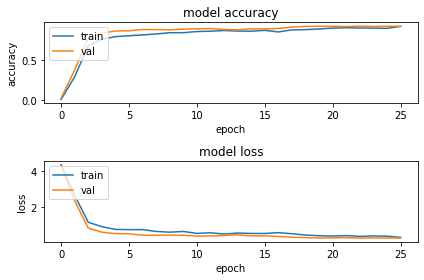

In [31]:
plt.subplot(211)
plt.plot(history['categorical_accuracy'])
plt.plot(history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')



plt.subplot(212)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.tight_layout()
plt.show()

In [27]:
model.save_pb_model(save_path="Model") # Save Model for export

first shape 4096
second shape 1024
third shape 512
INFO:tensorflow:Restoring parameters from checkpoints/model_checkpoint.ckpt-1200


INFO:tensorflow:Restoring parameters from checkpoints/model_checkpoint.ckpt-1200


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: Model/saved_model.pb


INFO:tensorflow:SavedModel written to: Model/saved_model.pb


In [32]:
!zip -r Model.zip Model/

  adding: Model/ (stored 0%)
  adding: Model/variables/ (stored 0%)
  adding: Model/variables/variables.index (deflated 53%)
  adding: Model/variables/variables.data-00000-of-00001 (deflated 50%)
  adding: Model/saved_model.pb (deflated 90%)


In [33]:
!zip -r checkpoints.zip checkpoints

  adding: checkpoints/ (stored 0%)
  adding: checkpoints/model_checkpoint.ckpt-1200.index (deflated 53%)
  adding: checkpoints/model_checkpoint.ckpt-999.meta (deflated 90%)
  adding: checkpoints/checkpoint (deflated 79%)
  adding: checkpoints/model_checkpoint.ckpt-1000.index (deflated 53%)
  adding: checkpoints/model_checkpoint.ckpt-1000.data-00000-of-00001 (deflated 50%)
  adding: checkpoints/model_checkpoint.ckpt-800.data-00000-of-00001 (deflated 50%)
  adding: checkpoints/model_checkpoint.ckpt-1299.meta (deflated 90%)
  adding: checkpoints/model_checkpoint.ckpt-1299.index (deflated 53%)
  adding: checkpoints/model_checkpoint.ckpt-800.index (deflated 53%)
  adding: checkpoints/model_checkpoint.ckpt-600.index (deflated 53%)
  adding: checkpoints/model_checkpoint.ckpt-1200.data-00000-of-00001 (deflated 50%)
  adding: checkpoints/model_checkpoint.ckpt-999.data-00000-of-00001 (deflated 51%)
  adding: checkpoints/model_checkpoint.ckpt-600.data-00000-of-00001 (deflated 44%)
  adding: check